In [ ]:
!pip install -q fastai timm kaggle --upgrade

from google.colab import userdata
from fastai.vision.all import *
import os, json, pathlib

os.environ['KAGGLE_USERNAME'] = 'frostyxbt'
os.environ['KAGGLE_KEY']      = userdata.get('frostyxbt')

In [ ]:
# make sure `path` is a Path object
from pathlib import Path
path = Path('/content/fruitveg')
path.mkdir(exist_ok=True)

# turn it into a plain Python string before handing off to the shell
download_path = str(path)

# now this will really write into /content/fruitveg, not “{path}”
!kaggle datasets download \
  -d kritikseth/fruit-and-vegetable-image-recognition \
  -p {download_path} --unzip -q

# verify immediately
print("got:", path.ls())   # should now show ['train','test','validation']

Dataset URL: https://www.kaggle.com/datasets/kritikseth/fruit-and-vegetable-image-recognition
License(s): CC0-1.0
got: [Path('/content/fruitveg/test'), Path('/content/fruitveg/validation'), Path('/content/fruitveg/train')]


In [ ]:
# Quick layout inspection
print((path).ls()[:5])        # root folders               # :contentReference[oaicite:3]{index=3}
for split in ['train','test','validation']:
    print(split, len((path/split).ls()))

[Path('/content/fruitveg/test'), Path('/content/fruitveg/validation'), Path('/content/fruitveg/train')]
train 36
test 36
validation 36


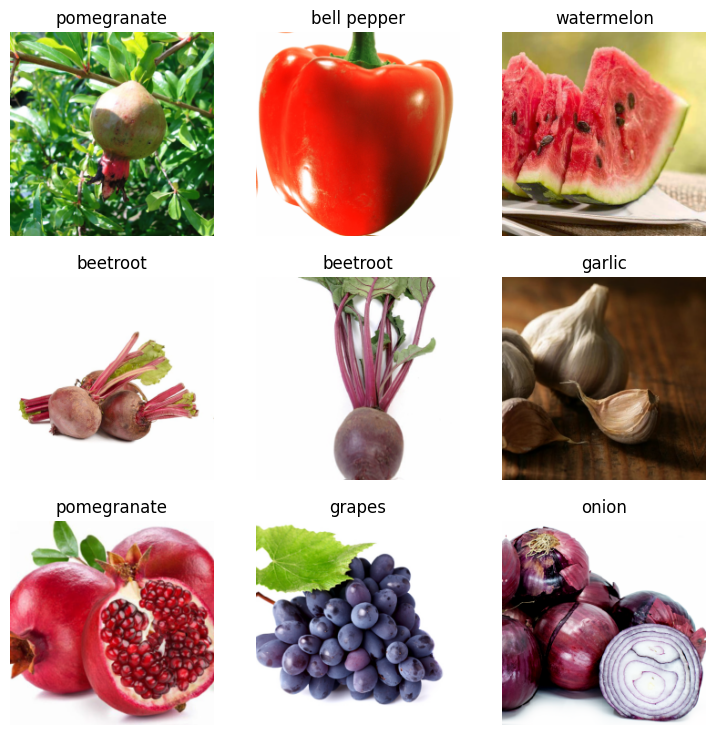

In [ ]:
from fastai.vision.core import PILImage
from PIL import Image       # pillow ≥ 10.0


class PILImageRGB(PILImage):
    # Open file → RGBA (kills palette warning) → RGB → wrap as fast-ai image.
    @classmethod
    def create(cls, fn, **kwargs):
        img = Image.open(fn)             # read as-is
        img = img.convert("RGBA")        # remove palette+alpha warning
        img = img.convert("RGB")         # drop alpha so aug_transforms stay fast
        return cls(img)                  # hand back a *wrapped* PILImage

# ---------------- DataBlock ---------------------------
item_size, batch_size = 460, 224
block = DataBlock(
    blocks    = (ImageBlock(cls=PILImageRGB), CategoryBlock),
    get_items = get_image_files,
    splitter  = GrandparentSplitter(train_name='train', valid_name='validation'),
    get_y     = parent_label,
    item_tfms = Resize(item_size),
    batch_tfms=[*aug_transforms(size=batch_size),
                Normalize.from_stats(*imagenet_stats)]
)
dls = block.dataloaders(path, bs=128, num_workers=8)
dls.show_batch()


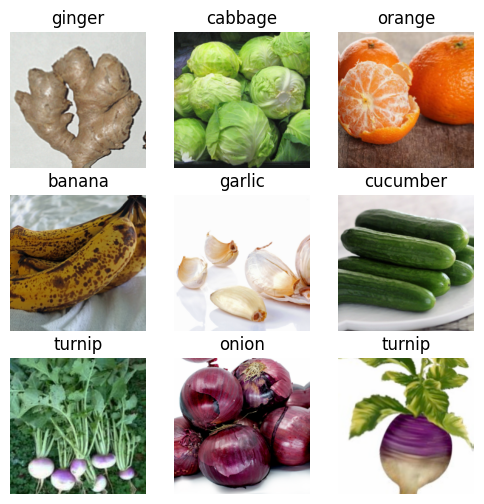

In [ ]:
dls.show_batch(max_n=9, figsize=(6,6))   # A.3.1           # :contentReference[oaicite:4]{index=4}

In [ ]:
block.summary(path)                      # A.3.3: print dataset sizes, types, and tfms :contentReference[oaicite:1]{index=1}

Setting-up type transforms pipelines
Found 3825 items
2 datasets of sizes 3115,351
Setting up Pipeline: PILImageRGB.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}


Building one sample
  Pipeline: PILImageRGB.create
    starting from
      /content/fruitveg/train/cabbage/Image_56.jpg
    applying PILImageRGB.create gives
      PILImageRGB mode=RGB size=2394x2385
  Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

    starting from
      /content/fruitveg/train/cabbage/Image_56.jpg
    applying parent_label gives
      cabbage
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
 gives
      TensorCategory(4)

Final sample: (PILImageRGB mode=RGB size=2394x2385, TensorCategory(4))


Found 3825 items
2 datasets of sizes 3115,351
Setting up Pipeline: PILImageRGB.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Setting 

/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,3.442730,0.447560,0.866097,0.864970,00:40


Better model found at epoch 0 with valid_loss value: 0.44756001234054565.


/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,1.893484,0.327448,0.903134,0.898315,00:39
1,1.747254,0.224168,0.923077,0.914193,00:37
2,1.622141,0.180618,0.951567,0.950857,00:37


Better model found at epoch 0 with valid_loss value: 0.3274476230144501.
Better model found at epoch 1 with valid_loss value: 0.22416843473911285.
Better model found at epoch 2 with valid_loss value: 0.1806175261735916.


/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


0.00014454397605732084 6.309573450380412e-07 0.0002754228771664202


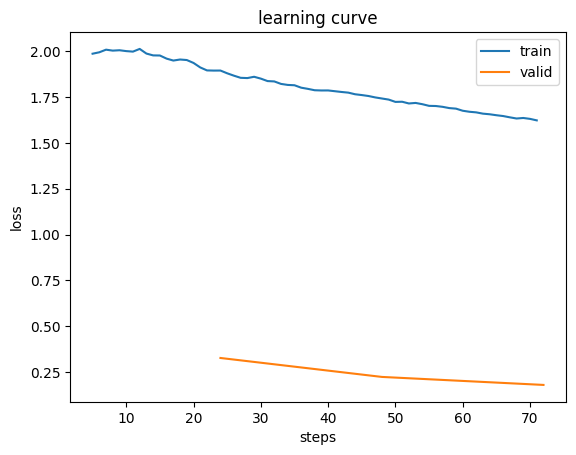

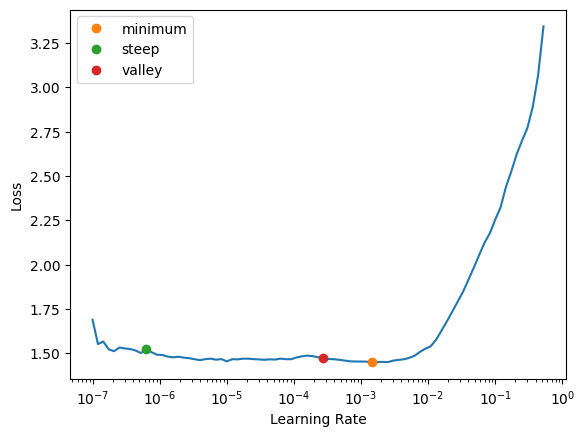

In [ ]:
learn = vision_learner(dls, resnet50, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, F1Score(average='macro')],     cbs=[
      MixUp(),
      SaveModelCallback(monitor='valid_loss', fname='best_res50')
    ]).to_fp16()  # B.3, B.6.3
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=1)   # baseline
learn.recorder.plot_loss()
lr_min, lr_steep, lr_valley = learn.lr_find(suggest_funcs=(minimum, steep, valley))
print(lr_min, lr_steep, lr_valley)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,1.491981,0.176628,0.948718,0.947265,00:38


Better model found at epoch 0 with valid_loss value: 0.17662841081619263.


/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,1.470843,0.174674,0.951567,0.950212,00:40
1,1.465625,0.173227,0.943020,0.941039,00:39
2,1.442147,0.152295,0.965812,0.965692,00:38
3,1.435266,0.146752,0.962963,0.962552,00:39
4,1.394570,0.137377,0.962963,0.962263,00:38
5,1.374503,0.128924,0.965812,0.965079,00:40
6,1.334361,0.128970,0.968661,0.967811,00:36
7,1.324719,0.128877,0.968661,0.967811,00:41
8,1.311709,0.128511,0.965812,0.964938,00:38
9,1.310803,0.126278,0.965812,0.964938,00:37


Better model found at epoch 0 with valid_loss value: 0.17467382550239563.
Better model found at epoch 1 with valid_loss value: 0.17322658002376556.
Better model found at epoch 2 with valid_loss value: 0.15229488909244537.
Better model found at epoch 3 with valid_loss value: 0.14675210416316986.
Better model found at epoch 4 with valid_loss value: 0.1373770534992218.
Better model found at epoch 5 with valid_loss value: 0.12892365455627441.
Better model found at epoch 7 with valid_loss value: 0.12887658178806305.
Better model found at epoch 8 with valid_loss value: 0.12851130962371826.
Better model found at epoch 9 with valid_loss value: 0.1262783706188202.


<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

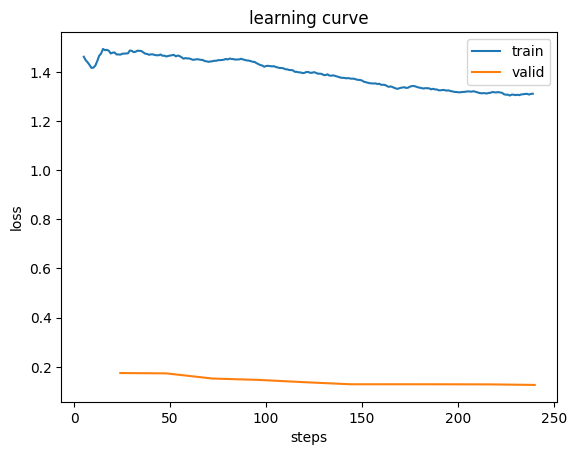

In [ ]:
learn.freeze()
learn.fit_one_cycle(1, lr_max=lr_min)
learn.unfreeze()
learn.fit_one_cycle(10, lr_max=slice(lr_min/10, lr_min), cbs=[GradientAccumulation(2)])
learn.recorder.plot_loss()

In [ ]:
# We removed MixUp for a short fine-turning phase to let the network focus on clean class boundaries once regularisation had done its job
learn.remove_cbs(MixUp)                 # sharpen decision boundaries
learn.fit_one_cycle(
    3,
    lr_max=slice(1e-5, 1e-4),           # tiny LR, keeps weights stable
    cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=2)]
)

/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.291776,0.141109,0.965812,0.965077,00:38
1,0.294021,0.141923,0.962963,0.962423,00:37
2,0.291829,0.143781,0.962963,0.962370,00:39


Better model found at epoch 0 with valid_loss value: 0.14110928773880005.
No improvement since epoch 0: early stopping


/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


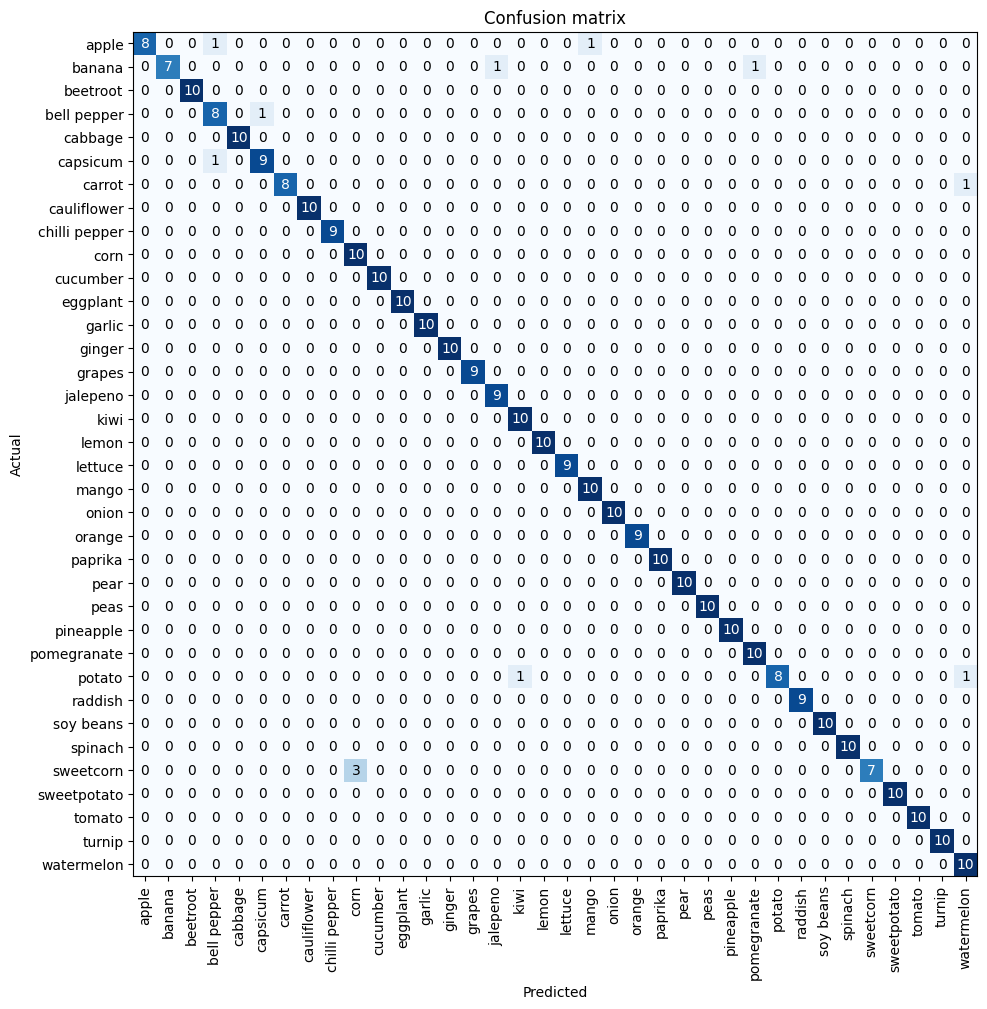

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(10,10))            # A.4.3   # :contentReference[oaicite:7]{index=7}

/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


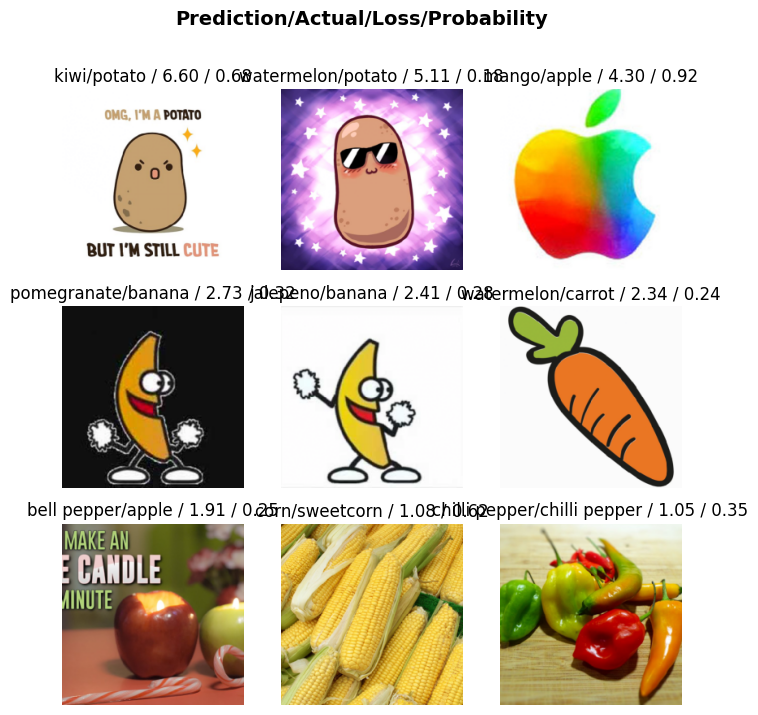

In [ ]:
interp.plot_top_losses(9, figsize=(8,8))                 # EXTRA    # :contentReference[oaicite:8]{index=8}

In [ ]:
learn.load('best_res50')
learn.export('fruitveg_res50.pkl')                       # :contentReference[oaicite:9]{index=9}

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:67: UserWarning: Saved file doesn't contain an optimizer state.
  elif with_opt: warn("Saved file doesn't contain an optimizer state.")


In [ ]:
import fastai
import torch
import timm

print(f"Fastai version: {fastai.__version__}")
print(f"PyTorch version: {torch.__version__}")
print(f"Timm version: {timm.__version__}")

import torchvision
print(f"Torchvision version: {torchvision.__version__}")

import sys
print(sys.version)
!pip freeze > requirements.txt

Fastai version: 2.8.1
PyTorch version: 2.6.0+cu124
Timm version: 1.0.15
Torchvision version: 0.21.0+cu124
3.11.12 (main, Apr  9 2025, 08:55:54) [GCC 11.4.0]
